# Exploring FSTs for Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from arsenal import timeit
from IPython.display import HTML
from genparse import FST, Float
from genparse.parse.earley import EarleyLM as CFGLM
from genparse.lm import MockLLM
from genparse.cfglm import locally_normalize, EOS, pcfg_check
from genparse.proposal import TokenProposal
from genparse.util import (
    LarkStuff,
    hf_tokenizer,
    about,
    bpe2term_approx,
)
from genparse.trace import TraceSWOR

## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [3]:
lark_stuff = LarkStuff(
    r"""

start: NAME

NAME: /(a|b)*c/

"""
)
foo = lark_stuff.char_cfg(decay=0.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

✔ PCFG


True

In [4]:
foo

Grammar {
  1.0: 0 → NAME
  1.0: NAME → ('NAME', 0)
  1.0: ('NAME', 1) → 
  0.03333333333333333: ('NAME', 0) → a ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → b ('NAME', 0)
  0.9333333333576115: ('NAME', 0) → c ('NAME', 1)
}

In [5]:
foo.cnf.language(3)

key,value
"('c',)",0.9333333333576115
"('b', 'c')",0.031111111111920383
"('b', 'b', 'c')",0.0010370370370640127
"('b', 'a', 'c')",0.0010370370370640127
"('a', 'c')",0.031111111111920383
"('a', 'b', 'c')",0.0010370370370640127
"('a', 'a', 'c')",0.0010370370370640127


In [6]:
lm = CFGLM(foo)

In [7]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 (('c',), 0.9333333333333406)
1 (('b', 'c'), 0.03111111111110799)
2 (('a', 'c'), 0.03111111111110799)
3 (('a', 'a', 'c'), 0.001037037037036821)
4 (('b', 'a', 'c'), 0.001037037037036821)
5 (('b', 'b', 'c'), 0.001037037037036821)
6 (('a', 'b', 'c'), 0.001037037037036821)
7 (('a', 'b', 'a', 'c'), 3.456790123455696e-05)
8 (('b', 'a', 'a', 'c'), 3.456790123455696e-05)
9 (('b', 'b', 'a', 'c'), 3.456790123455696e-05)
10 (('a', 'a', 'a', 'c'), 3.456790123455696e-05)
11 (('b', 'a', 'b', 'c'), 3.456790123455696e-05)
12 (('a', 'a', 'b', 'c'), 3.456790123455696e-05)
13 (('a', 'b', 'b', 'c'), 3.456790123455696e-05)
14 (('b', 'b', 'b', 'c'), 3.456790123455696e-05)


In [8]:
H = hf_tokenizer()
about(H.fst)

states: 98036, trim: 98036


Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [9]:
# b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber
# about(b2c)

In [10]:
b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

('c',)
total weight of BPE sequences (i.e., ambiguity): 1.0


('b', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


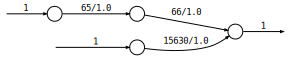

('b', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


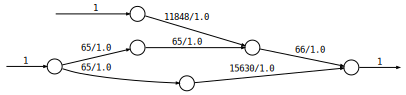

('b', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


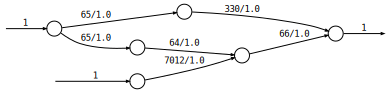

('a', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


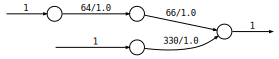

('a', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 4.0


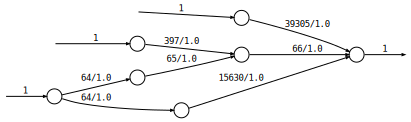

('a', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


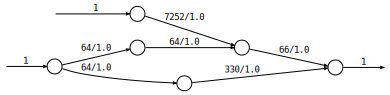

In [11]:
for x in foo.cnf.language(3):
    display(HTML('<hr/>'))
    print(x)
    bpe_x = b2c(None, x).epsremove.trim
    print('total weight of BPE sequences (i.e., ambiguity):', bpe_x.total_weight())
    display(bpe_x)
    print()

In [12]:
tmp = (b2c @ foo).trim()

In [13]:
L = 5

In [14]:
c = Float.chart()
for (
    x,
    w,
) in tmp.cnf.language(5).items():
    y = H.tokenizer.decode(x)
    if len(y) > L:
        continue
    c[y] += w

In [15]:
ambig = Float.chart({x: b2c(None, x).total_weight() for x in c})

In [16]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [17]:
cc = Float.chart()
for x, w in foo.cnf.language(L + 2).items():
    if len(x) > L:
        continue
    cc[''.join(x)] += w
# cc

In [18]:
ccc.assert_equal(cc, tol=1e-20)

In [19]:
# cc.metric(c)

In [20]:
# tmp.trim(bottomup_only=True)

In [21]:
# show_grammar(tmp, showzero=True)

In [22]:
# print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [23]:
# for q in c2t.states:
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [24]:
# {x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [25]:
# len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [26]:
# tmp.cnf.language(4)

In [27]:
# show_grammar(tmp)

In [28]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()
pcfg_check(p)

✔ PCFG


True

In [35]:
lm2 = CFGLM(p.cnf)

In [36]:
# lm2.sample(verbose=1)

In [37]:
# context = (64,65,6485,39305)
context = (
    64,
    65,
    6485,
)

In [38]:
char_context = H.tokenizer.decode(context)
char_context

'ababb'

In [39]:
df = []
for x, w in sorted(lm2.p_next(context).normalize().items(), key=lambda kv: -kv[1]):
    df.append((x, (H.tokenizer.decode([x]) if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

,chars,prob
token_id,,
48910,abba,0.419317
66,c,0.419316
6485,abb,0.064312
64,a,0.032139
65,b,0.032138
15630,bc,0.013977
330,ac,0.013977
7012,ba,0.001071
11848,bb,0.001071


In [40]:
lm.p_next(char_context).normalize()

key,value
c,0.9333333333333405
a,0.03333333333332973
b,0.03333333333332973


## Lexing

In [41]:
lark_stuff = LarkStuff(
    r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

"""
)

In [42]:
foo = lark_stuff.char_cfg(0.1)

In [43]:
# foo['NAME'].trim().agenda()

In [44]:
# foo.agenda()

In [45]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [46]:
# foo

In [47]:
lm = CFGLM(foo)

In [48]:
trace = TraceSWOR()
for _ in range(15):
    print('mass=', trace.root.mass)
    with trace:
        print(''.join(lm.sample(draw=trace, prob=False)))

mass= 1.0
SELECT * FROM eh </s>
mass= 0.9998712672786744
SELECT * FROM f </s>
mass= 0.9651134325208375
SELECT * FROM o </s>
mass= 0.9303555977630006
SELECT * FROM l </s>
mass= 0.8955977630051637
SELECT * FROM v </s>
mass= 0.8608399282473268
SELECT * FROM e </s>
mass= 0.8260820934894899
SELECT * FROM s </s>
mass= 0.791324258731653
SELECT * FROM h </s>
mass= 0.7565664239738162
SELECT * FROM j </s>
mass= 0.7218085892159795
SELECT * FROM i </s>
mass= 0.6870507544581426
SELECT * FROM a </s>
mass= 0.6522929197003059
SELECT * FROM evj </s>
mass= 0.6522924429124491
SELECT * FROM y </s>
mass= 0.6175346081546124
SELECT * FROM ow </s>
mass= 0.6174058754332871
SELECT * FROM r </s>


In [49]:
cfg = lark_stuff.convert().renumber()

In [50]:
c2t = lark_stuff.transducer(ignore='', decay=0.0125)
len(c2t.states)

25

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [51]:
x = 'SELECT * FROM data'

In [52]:
list(lark_stuff.lex(x))

[Token('SELECT', 'SELECT'),
 Token('WS', ' '),
 Token('STAR', '*'),
 Token('WS', ' '),
 Token('FROM', 'FROM'),
 Token('WS', ' '),
 Token('NAME', 'data')]

However, this string can lex many different ways:

In [53]:
ambig = (
    (FST.from_string(x, Float) @ c2t)
    .trim.project(1)
    .epsremove.trim.to_cfg()
    .cnf.language(15)
)

In [54]:
# ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [55]:
for y in ambig:
    v = cfg.prefix_weight(y)  # show all options with a nonzero prefix weight
    if v == 0:
        continue
    print(v, y)

1.0 ('SELECT', 'WS', 'STAR', 'WS', 'FROM', 'WS', 'NAME')


In [56]:
# ((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [57]:
# (P.T @ cfg).trim().cnf.language(100)

In [58]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [59]:
pcfg_check(pcfg_t)

✔ PCFG


True

In [60]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [61]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [62]:
lm = CFGLM(pcfg_t.cnf)

In [63]:
for _ in range(10):
    print(''.join(lm.sample(prob=False)))

SELECT * FROM xg </s>
SELECT * FROM b </s>
SELECT * FROM ye </s>
SELECT * FROM et </s>
SELECT * FROM w </s>
SELECT * FROM m </s>
SELECT * FROM x </s>
SELECT * FROM vsj </s>
SELECT * FROM si </s>
SELECT * FROM gz </s>


In [64]:
lm.p_next('SELECT * FROM ')

key,value
d,0.03846153846151434
n,0.03846153846151434
h,0.03846153846151434
j,0.03846153846151434
m,0.03846153846151434
p,0.03846153846151434
z,0.03846153846151434
x,0.03846153846151434
a,0.03846153846151434
t,0.03846153846151434


## BPE Basics

In [65]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [66]:
b2c = hf_tk.fst
len(b2c.states)

98036

In [67]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

[46506, 1635, 16034, 1366]

In [68]:
[tokenizer.decode([bb]) for bb in b]

['SELECT', ' *', ' FROM', ' data']

In [69]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

composition (4.0614 sec)


states: 490180, trim: 23


In [70]:
c.trim

We can build this "transducer" more efficiently

In [71]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [72]:
x = x = 'SELECT * FROM data'

In [73]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

states: 68, trim: 68


composition (0.8206 sec)
trim (0.0010 sec)


In [74]:
# bs.trim

The automaton below describes all the BPE sequences that generate the string `x` and the number below is the total weight of these paths (in the count semiring these are the number of distinct paths):

In [75]:
bs.trim.project(0).epsremove.trim.total_weight()

7904.0

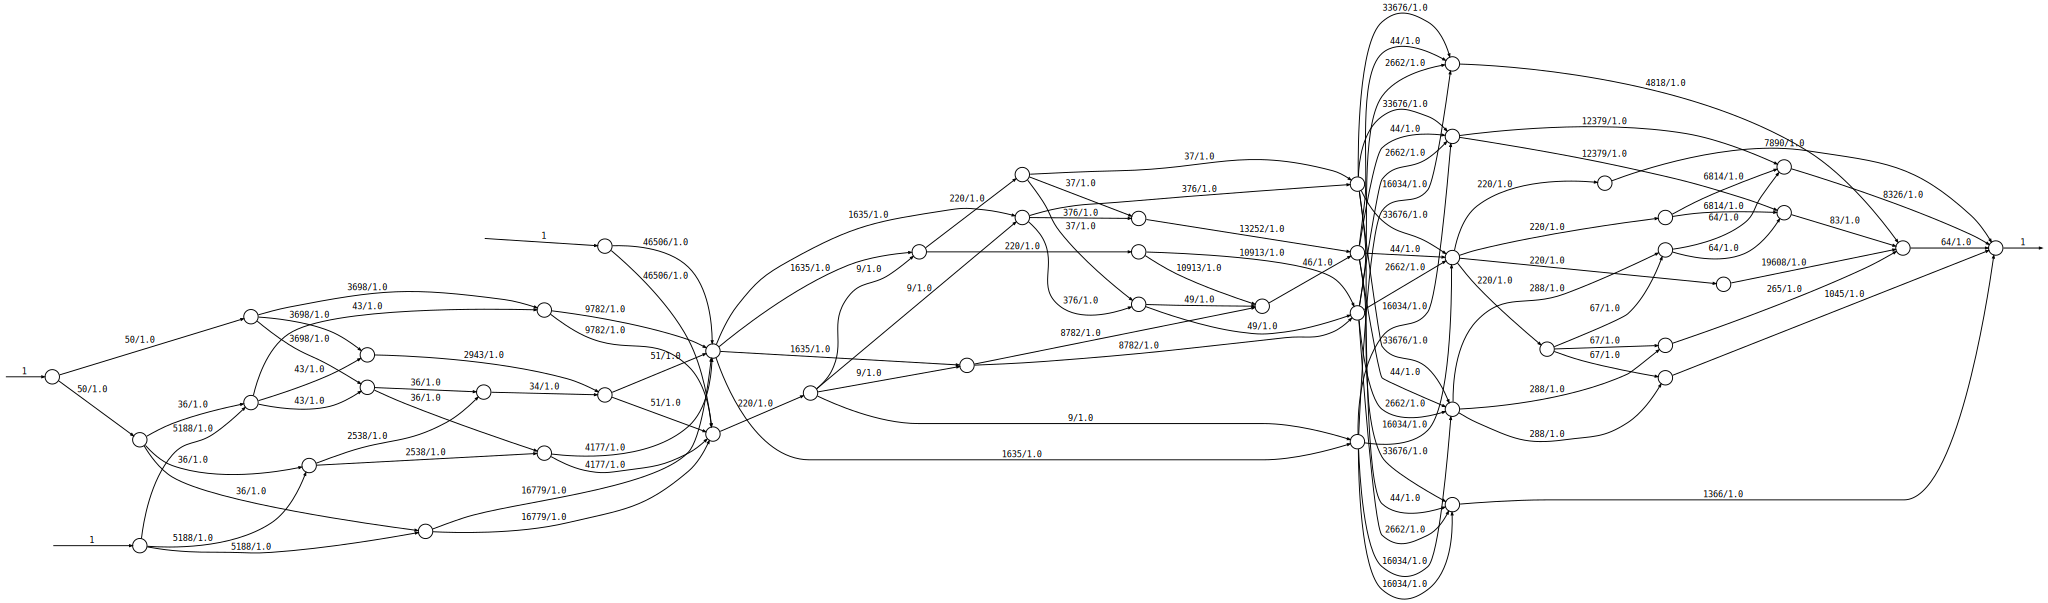

In [76]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [77]:
# for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## The Grafting Heuristic

In [78]:
lark_stuff = LarkStuff(
    r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
"""
)

foo = lark_stuff.char_cfg(0.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(foo)

In [79]:
print(''.join(lm.sample(prob=False)))

SELECT * FROM data </s>


In [80]:
H = hf_tokenizer()

In [81]:
bpe_lm = TokenProposal(
    guide=lm, llm=MockLLM(V={x for _, x in H.pairs}, eos=H.tokenizer.eos_token)
)

In [82]:
lm.p_next('')

key,value
S,0.9999999999999999


In [83]:
bpe_lm._prompt = ''
bpe_lm._p_next('')

key,value
S,0.3333333333333334
SE,0.3333333333333334
SELECT,0.33333333333333326


In [84]:
lm.p_next('SELECT ')

key,value
A,0.002147021836068107
z,0.0020452525283278984
a,0.008518336227937937
r,0.00016843534029367416
y,0.005962835359556556
*,0.9699939597005802
s,0.0004910651320515283
v,0.005962835359556556
C,0.0010520406996733724
M,0.0007364284897713606


In [85]:
bpe_lm._p_next('SELECT ')

key,value
*,0.969835318145591
a,0.008516943062453135
v,0.005961860143717195
y,0.005961860143717195
g,0.0029213114704214256
A,0.0021466706927653436
z,0.002044918029294997
C,0.0010518686394550183
M,0.0007363080476185128
s,0.0004909848188337288


In [86]:
ys = bpe_lm.sample()
ys

('SELECT * FROM data </s>', 5.8108118515745706e-05)